In [127]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import (
    MobileNet,
    MobileNetV2,
    Xception,
    ResNet50V2,
    DenseNet201,
    DenseNet169,
    InceptionV3,
    InceptionResNetV2,
)
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

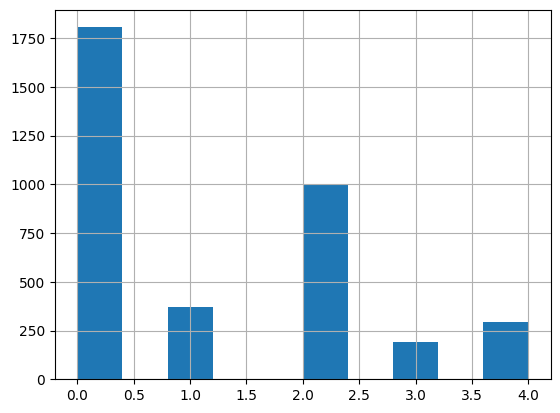

In [128]:
train_df = pd.read_csv("./aptos2019-blindness-detection/train.csv")
train_df['diagnosis'].hist()
train_df.head()

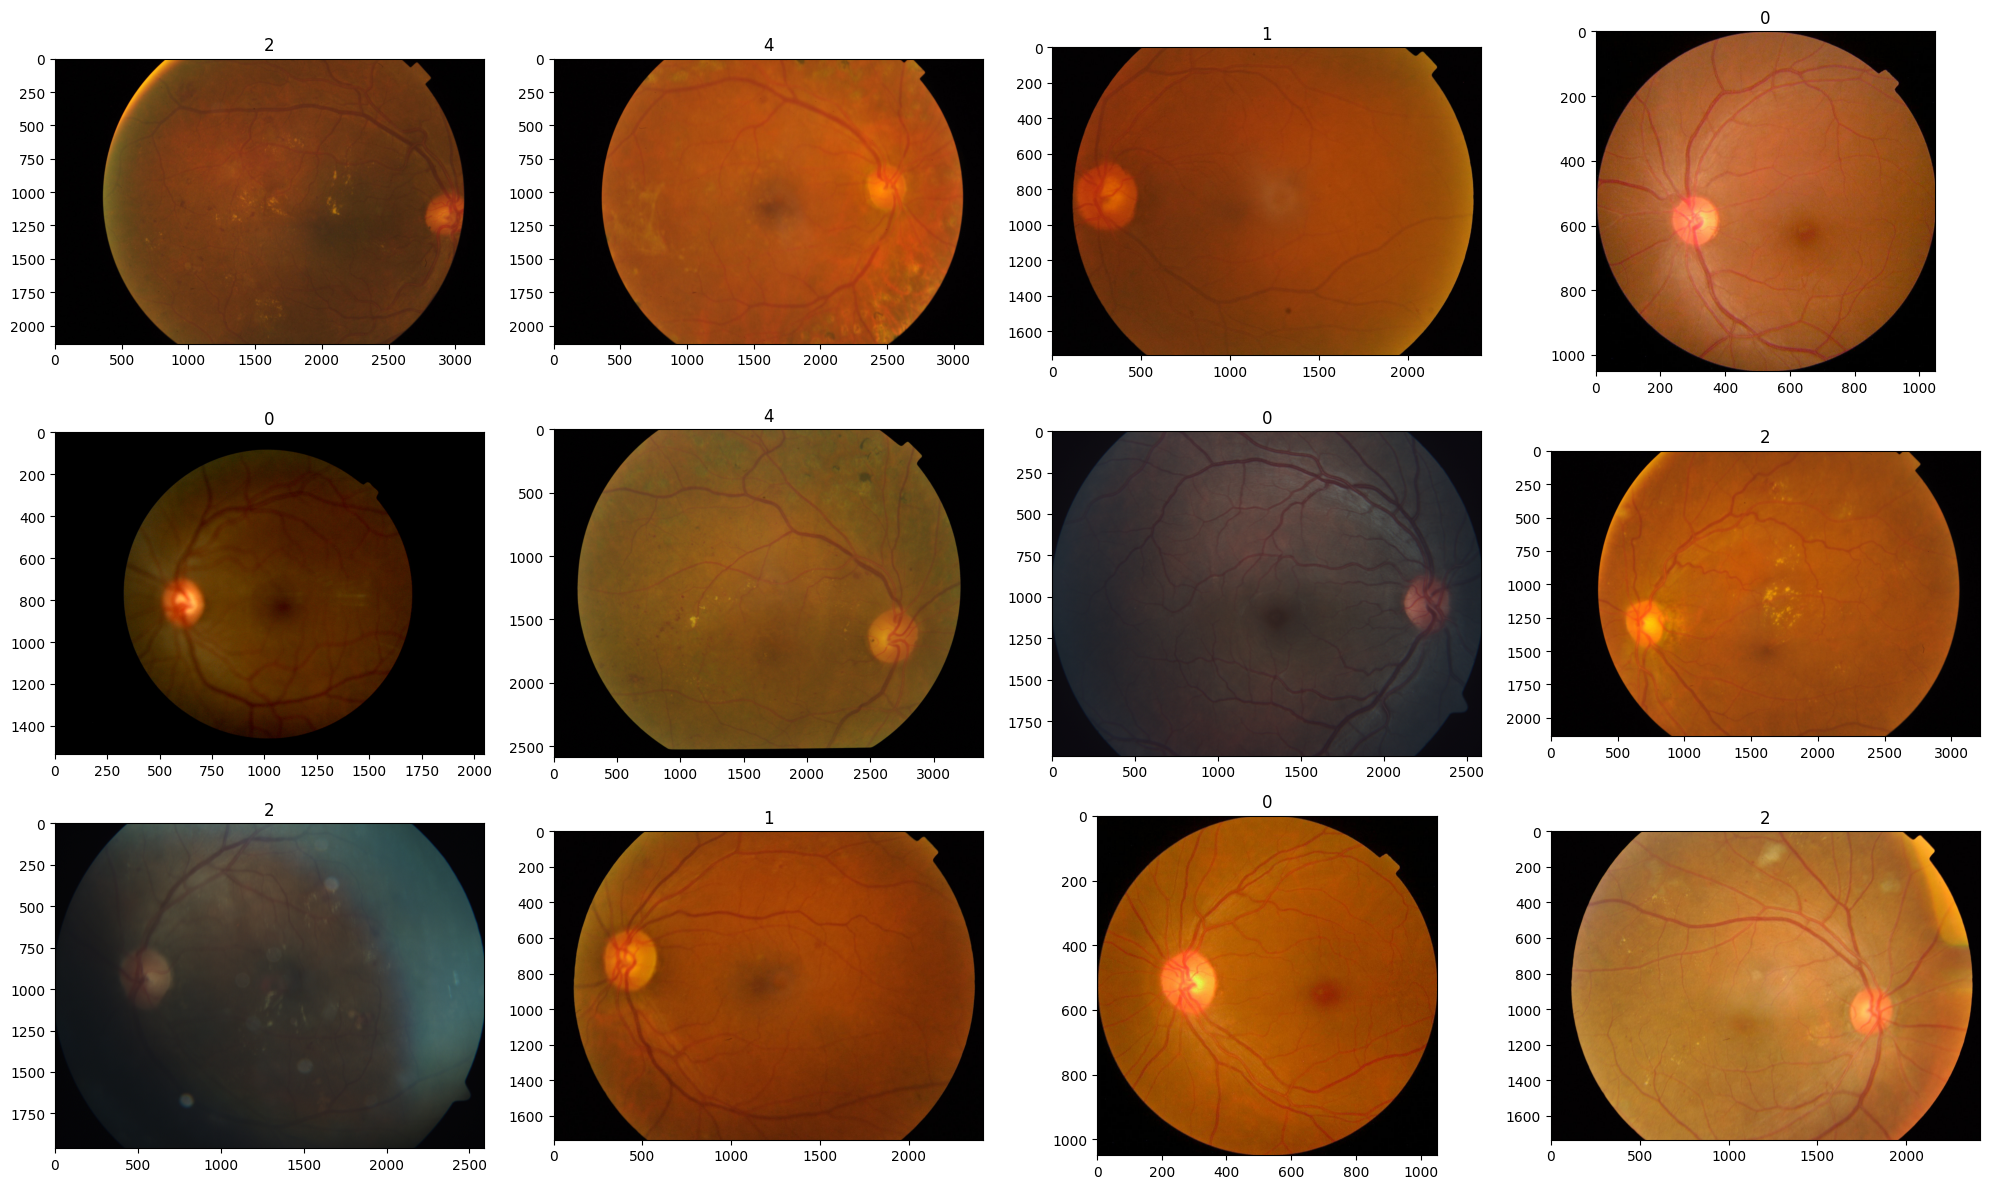

In [129]:
def display_samples(df, columns=4, rows=3):
    fig = plt.figure(figsize=(5 * columns, 4 * rows))
    for i in range(columns * rows):
        image_path = df.loc[i, "id_code"]
        image_id = df.loc[i, "diagnosis"]
        img = cv2.imread(f"aptos2019-blindness-detection/train_images/{image_path}.png")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i + 1)
        plt.title(image_id)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

display_samples(train_df)

In [130]:
def preprocess_aptos_image(image_path, target_size=(224, 224)):
    # Read the image and resize
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Green channel enhancement (emphasizing blood vessels)
    green_channel = img[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    green_channel = clahe.apply(green_channel)
    img[:, :, 1] = green_channel
    
    # Reduce yellow tones (reduce red and green channels by 20%)
    img[:, :, 0] = img[:, :, 0] * 0.8
    img[:, :, 1] = img[:, :, 1] * 0.8
    
    # Sharpen the image to enhance
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)
    
    img = cv2.GaussianBlur(img, (5, 5), 0)
    
    img = img / 255.0
    
    return img

def load_data(image_dir, csv_file, target_size=(224, 224), label_column="diagnosis"):
    df = pd.read_csv(csv_file)
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(image_dir, row["id_code"] + ".png")
        img = preprocess_aptos_image(img_path, target_size)
        images.append(img)
        labels.append(row[label_column])
    return np.array(images), np.array(labels)

train_images, train_labels = load_data(
    "aptos2019-blindness-detection/train_images",
    "aptos2019-blindness-detection/train_updated.csv"
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img

# Load the CSV file
df = pd.read_csv("./aptos2019-blindness-detection/train.csv")

# Mapping of diagnosis to category names
categories = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate"}

datagen = ImageDataGenerator(
     rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="reflect"
)


def augment_images(image_paths, diagnosis, required_total_count, base_dir, df):
    current_count = len(image_paths)
    generated_count = 0
    target_count = required_total_count - current_count
    new_records = []

    while generated_count < target_count:
        for img_path in image_paths:
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            # Generate a batch of augmented images
            for batch in datagen.flow(x, batch_size=1):
                # Create a new file name
                new_image_name = f"aug_{generated_count}_{os.path.basename(img_path)}"
                new_image_path = os.path.join(base_dir, new_image_name)

                # Convert the NumPy array to an image
                batch_image = np.squeeze(batch, axis=0).astype(np.uint8)
                image = Image.fromarray(batch_image)

                # Save the augmented image
                image.save(new_image_path)

                # Prepare new record for CSV
                new_records.append(
                    {"id_code": new_image_name.split(".")[0], "diagnosis": diagnosis}
                )

                generated_count += 1
                if generated_count >= target_count:
                    break
        if generated_count >= target_count:
            break

    # Concatenate new records with the existing DataFrame
    new_df = pd.DataFrame(new_records)
    df = pd.concat([df, new_df], ignore_index=True)
    return df


base_dir = "./aptos2019-blindness-detection/train_images/"

# Desired image counts
target_counts = {
    1: 664,  # Mild DR
    2: 186,  # Moderate DR
    0: 62,  # No DR
    4: 310,  # Proliferative DR
    3: 352,  # Severe DR
}

for diagnosis, category in categories.items():
    image_paths = (
        df[df["diagnosis"] == diagnosis]["id_code"]
        .apply(lambda x: os.path.join(base_dir, f"{x}.png"))
        .tolist()
    )

    # Augment images to reach the desired total
    df = augment_images(image_paths, diagnosis, target_counts[diagnosis], base_dir, df)

# Save the updated CSV file
df.to_csv("train_updated.csv", index=False)

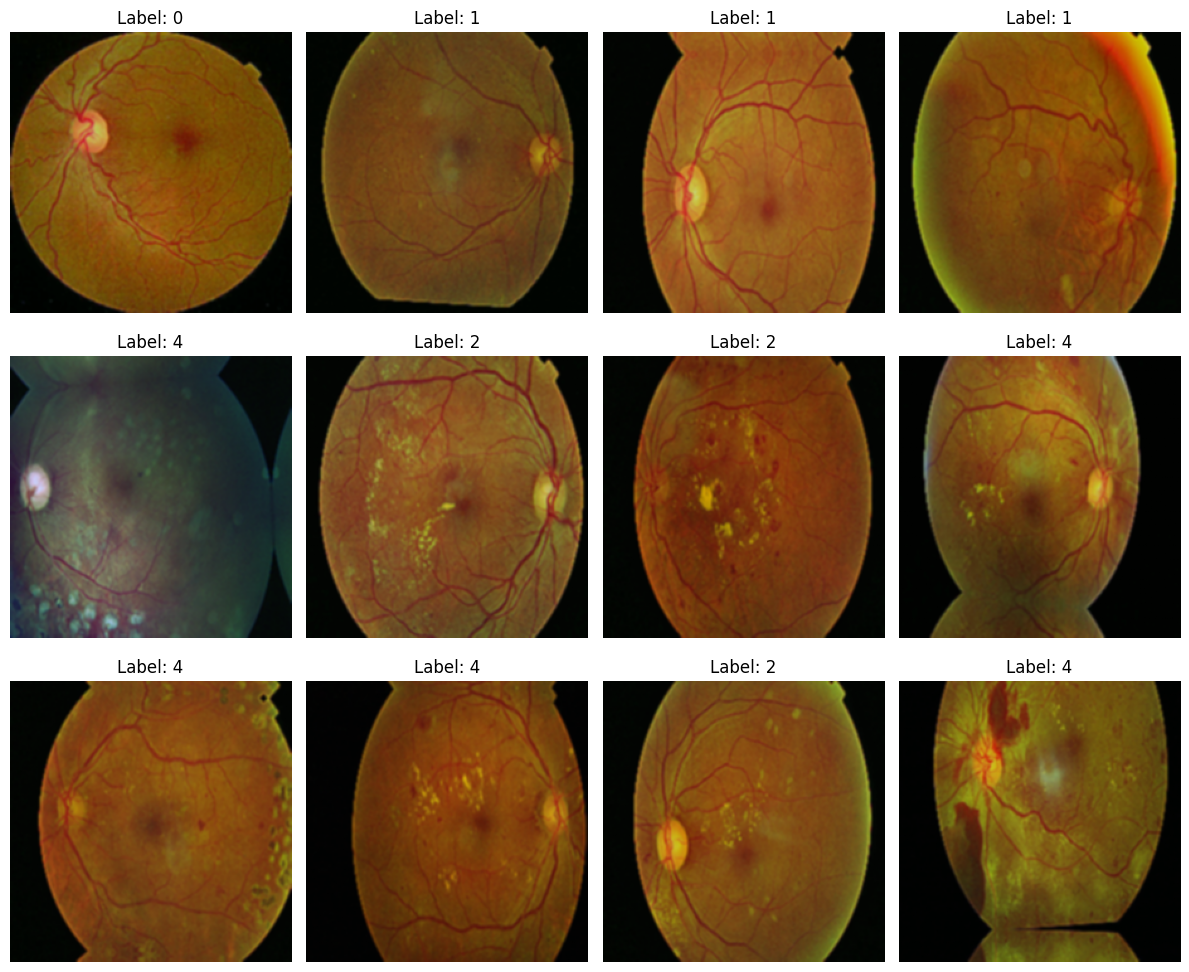

In [131]:
def plot_sample_images(images, labels, num_samples=12):
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(12, 10))
    for i, idx in enumerate(indices):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {labels[idx]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_images(train_images, train_labels)

In [132]:
EPOCHS = 30

# Define Callbacks
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [133]:
# Encode Labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
num_classes = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, num_classes)

# Split Data
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.3, random_state=42)
# X_train,y_train=train_images, train_labels
# X_val,y_val = train_images, train_labels

### MobileNet Model

Training model...
Epoch 1/30


c:\Users\User\Desktop\from pendrive\Thesis\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 150s 909ms/step - accuracy: 0.6255 - f1_score: 0.5499 - loss: 1.4924 - precision: 0.6671 - recall: 0.5789 - val_accuracy: 0.2644 - val_f1_score: 0.2186 - val_loss: 5.6591 - val_precision: 0.2639 - val_recall: 0.2574 - learning_rate: 0.0010
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 140s 895ms/step - accuracy: 0.7548 - f1_score: 0.7003 - loss: 0.7459 - precision: 0.8101 - recall: 0.7042 - val_accuracy: 0.7178 - val_f1_score: 0.6696 - val_loss: 0.7834 - val_precision: 0.7605 - val_recall: 0.6758 - learning_rate: 0.0010
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 143s 912ms/step - accuracy: 0.8024 - f1_score: 0.7484 - loss: 0.6139 - precision: 0.8414 - recall: 0.7599 - val_accuracy: 0.6536 - val_f1_score: 0.5929 - val_loss: 0.9430 - val_precision: 0.6733 - val_recall: 0.6329 - learning_rate: 0.0010
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 143s 909ms/step - accuracy: 0.8213 - f1_score: 0.7737 - loss: 0.5413 - precision: 0.8557 - recall: 0.7932 - val_accuracy: 0.7926 - 

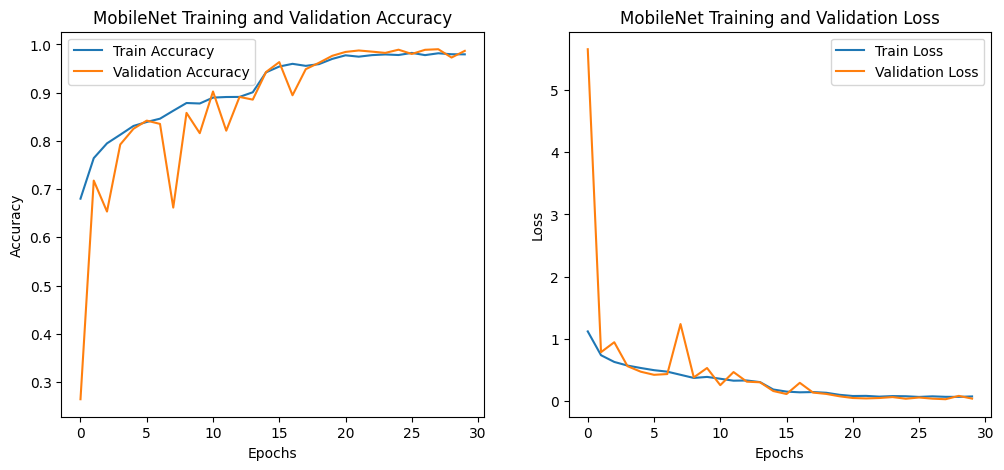

In [8]:
MobileNet_base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
MobileNet_x = MobileNet_base_model.output
MobileNet_x = GlobalAveragePooling2D()(MobileNet_x)
MobileNet_x = Dense(1024, activation="relu")(MobileNet_x)
MobileNet_x = BatchNormalization()(MobileNet_x)
MobileNet_predictions = Dense(num_classes, activation="softmax")(MobileNet_x)
MobileNet_model = Model(inputs=MobileNet_base_model.input, outputs=MobileNet_predictions)

MobileNet_model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), F1Score(name='f1_score')]
)

# Data Augmentation
MobileNet_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Calculate class weights
MobileNet_train_labels_int = np.argmax(train_labels, axis=1)
MobileNet_class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(MobileNet_train_labels_int), y=MobileNet_train_labels_int)
MobileNet_class_weights_dict = dict(enumerate(MobileNet_class_weights))

# %% Train the Model
print("Training model...")
MobileNet_history = MobileNet_model.fit(
    MobileNet_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=MobileNet_datagen.flow(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    class_weight=MobileNet_class_weights_dict
)

MobileNet_model.save("MobileNet_model.h5")

# Accuracy
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(MobileNet_history.history['accuracy'], label='Train Accuracy')
plt.plot(MobileNet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNet Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(MobileNet_history.history['loss'], label='Train Loss')
plt.plot(MobileNet_history.history['val_loss'], label='Validation Loss')
plt.title('MobileNet Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


#### Confusion Matrix

Validation accuracy: 0.9902
Validation loss: 0.0268
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step


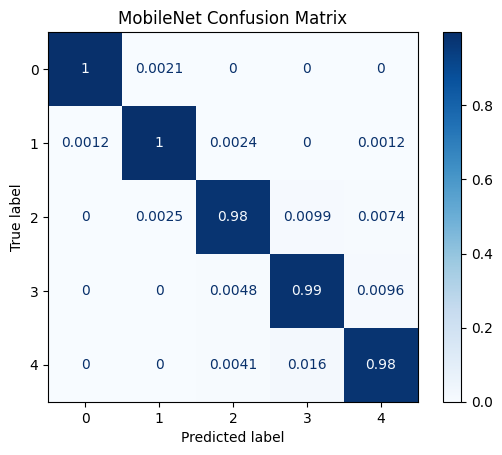

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

model = load_model("MobileNet_model.h5")

test = MobileNet_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test[1]:.4f}")
print(f"Validation loss: {test[0]:.4f}")

# Predict and compute confusion matrix
MobileNet_y_val_pred = MobileNet_model.predict(X_val)
MobileNet_y_val_pred_classes = np.argmax(MobileNet_y_val_pred, axis=1)
MobileNet_y_val_true = np.argmax(y_val, axis=1)
MobileNet_conf_matrix = confusion_matrix(MobileNet_y_val_true, MobileNet_y_val_pred_classes)
MobileNet_normalized_conf_matrix = MobileNet_conf_matrix.astype("float") / MobileNet_conf_matrix.sum(axis=1)[:, np.newaxis]

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=MobileNet_normalized_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("MobileNet Confusion Matrix")
plt.show()


### MobileNetV2 Model

Training model...
Epoch 1/30


c:\Users\User\Desktop\from pendrive\Thesis\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.6126 - f1_score: 0.5524 - loss: 1.2721 - precision: 0.6699 - recall: 0.5428 - val_accuracy: 0.3621 - val_f1_score: 0.1063 - val_loss: 14.3868 - val_precision: 0.3621 - val_recall: 0.3621 - learning_rate: 0.0010
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.7588 - f1_score: 0.7028 - loss: 0.7607 - precision: 0.8071 - recall: 0.6932 - val_accuracy: 0.3621 - val_f1_score: 0.1063 - val_loss: 11.1955 - val_precision: 0.3621 - val_recall: 0.3621 - learning_rate: 0.0010
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7898 - f1_score: 0.7319 - loss: 0.6399 - precision: 0.8414 - recall: 0.7389 - val_accuracy: 0.3621 - val_f1_score: 0.1063 - val_loss: 14.8515 - val_precision: 0.3621 - val_recall: 0.3621 - learning_rate: 0.0010
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8049 - f1_score: 0.7538 - loss: 0.6104 - precision: 0.8427 - recall: 0.7614 - val_accuracy: 0.3635 - val_f1_sc

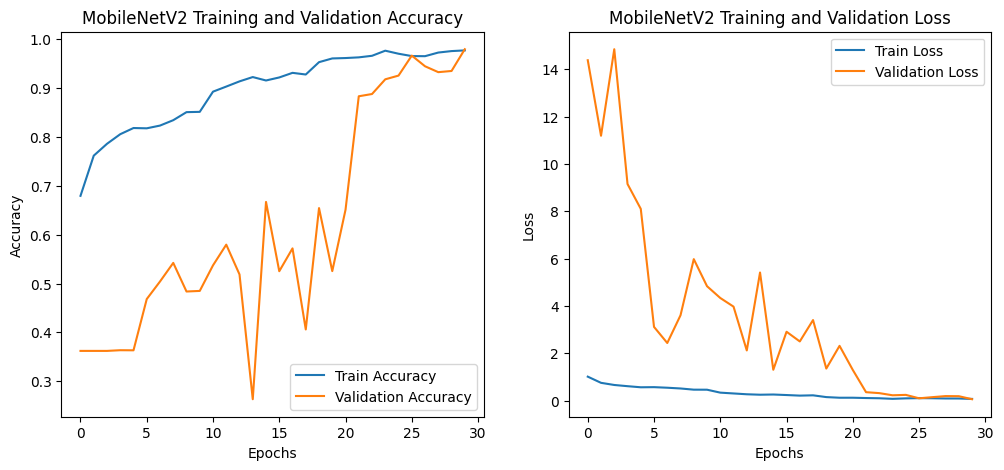

In [14]:
# Load MobileNetV2 base model
MobileNetV2_base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Add layers to the base model
MobileNetV2_x = MobileNetV2_base_model.output
MobileNetV2_x = GlobalAveragePooling2D()(MobileNetV2_x)
MobileNetV2_x = Dense(1024, activation="relu")(MobileNetV2_x)
MobileNetV2_x = BatchNormalization()(MobileNetV2_x)
MobileNetV2_predictions = Dense(num_classes, activation="softmax")(MobileNetV2_x)

# Final model
MobileNetV2_model = Model(inputs=MobileNetV2_base_model.input, outputs=MobileNetV2_predictions)

# Compile the model
MobileNetV2_model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), F1Score(name='f1_score')]
)

# Data Augmentation
MobileNetV2_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Calculate class weights
MobileNetV2_train_labels_int = np.argmax(train_labels, axis=1)
MobileNetV2_class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(MobileNetV2_train_labels_int), y=MobileNetV2_train_labels_int)
MobileNetV2_class_weights_dict = dict(enumerate(MobileNetV2_class_weights))

# Train the Model
print("Training model...")
MobileNetV2_history = MobileNetV2_model.fit(
    MobileNetV2_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=MobileNetV2_datagen.flow(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    class_weight=MobileNetV2_class_weights_dict
)

# Save the model
MobileNetV2_model.save("MobileNetV2_model.h5")

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(MobileNetV2_history.history['accuracy'], label='Train Accuracy')
plt.plot(MobileNetV2_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNetV2 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(MobileNetV2_history.history['loss'], label='Train Loss')
plt.plot(MobileNetV2_history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Confusion Matrix

Validation accuracy: 0.9687
Validation loss: 0.0910
156/156 ━━━━━━━━━━━━━━━━━━━━ 25s 159ms/step


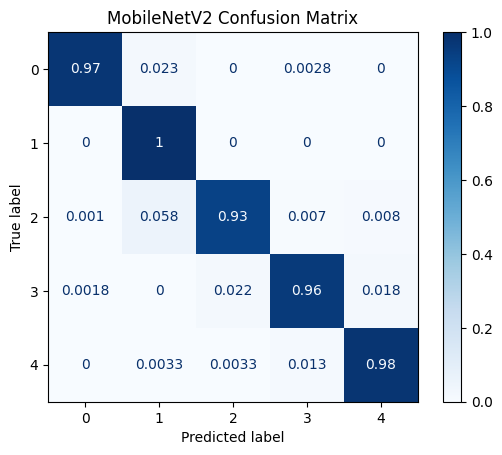

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

MobileNetV2_model = load_model("MobileNetV2_model.h5")

test = MobileNetV2_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test[1]:.4f}")
print(f"Validation loss: {test[0]:.4f}")

# Predict and compute confusion matrix
MobileNetV2_y_val_pred = MobileNetV2_model.predict(X_val)
MobileNetV2_y_val_pred_classes = np.argmax(MobileNetV2_y_val_pred, axis=1)
MobileNetV2_y_val_true = np.argmax(y_val, axis=1)
MobileNetV2_conf_matrix = confusion_matrix(MobileNetV2_y_val_true, MobileNetV2_y_val_pred_classes)
MobileNetV2_normalized_conf_matrix = MobileNetV2_conf_matrix.astype("float") / MobileNetV2_conf_matrix.sum(axis=1)[:, np.newaxis]

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=MobileNetV2_normalized_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("MobileNetV2 Confusion Matrix")
plt.show()

### Xception Model

Training model...
Epoch 1/30


c:\Users\User\Desktop\from pendrive\Thesis\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.5881 - f1_score: 0.5333 - loss: 1.2102 - precision: 0.7316 - recall: 0.4516 - val_accuracy: 0.7153 - val_f1_score: 0.6185 - val_loss: 0.6623 - val_precision: 0.8046 - val_recall: 0.6211 - learning_rate: 0.0010
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.7500 - f1_score: 0.6888 - loss: 0.7703 - precision: 0.8142 - recall: 0.6608 - val_accuracy: 0.7577 - val_f1_score: 0.7016 - val_loss: 0.6444 - val_precision: 0.8199 - val_recall: 0.6941 - learning_rate: 0.0010
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.7987 - f1_score: 0.7468 - loss: 0.6743 - precision: 0.8418 - recall: 0.7425 - val_accuracy: 0.8618 - val_f1_score: 0.8274 - val_loss: 0.3819 - val_precision: 0.8848 - val_recall: 0.8287 - learning_rate: 0.0010
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.8336 - f1_score: 0.7882 - loss: 0.5458 - precision: 0.8660 - recall: 0.7939 - val_accuracy: 0.8562 - val_f1_score

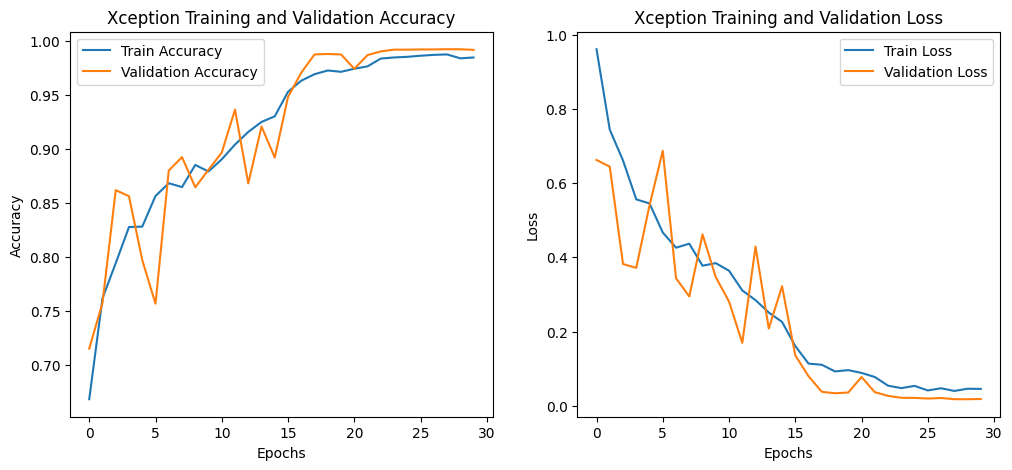

In [10]:
Xception_base_model = Xception(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
Xception_x = Xception_base_model.output
Xception_x = GlobalAveragePooling2D()(Xception_x)
Xception_x = Dense(1024, activation="relu")(Xception_x)
Xception_x = BatchNormalization()(Xception_x)
Xception_predictions = Dense(num_classes, activation="softmax")(Xception_x)
Xception_model = Model(
    inputs=Xception_base_model.input, outputs=Xception_predictions
)

Xception_model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        F1Score(name="f1_score"),
    ],
)

# Data Augmentation
Xception_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Calculate class weights
Xception_train_labels_int = np.argmax(train_labels, axis=1)
Xception_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(Xception_train_labels_int),
    y=Xception_train_labels_int,
)
Xception_class_weights_dict = dict(enumerate(Xception_class_weights))

# %% Train the Model
print("Training model...")
Xception_history = Xception_model.fit(
    Xception_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    class_weight=Xception_class_weights_dict,
)

Xception_model.save("Xception_model.h5")

# Accuracy
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(Xception_history.history["accuracy"], label="Train Accuracy")
plt.plot(Xception_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Xception Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(Xception_history.history["loss"], label="Train Loss")
plt.plot(Xception_history.history["val_loss"], label="Validation Loss")
plt.title("Xception Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### Confusion Matrix

Validation accuracy: 0.9914
Validation loss: 0.0184
156/156 ━━━━━━━━━━━━━━━━━━━━ 64s 409ms/step


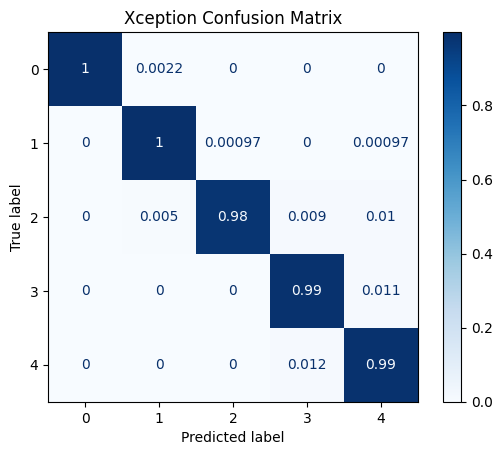

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

model = load_model("Xception_model.h5")

test = Xception_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test[1]:.4f}")
print(f"Validation loss: {test[0]:.4f}")

# Predict and compute confusion matrix
Xception_y_val_pred = Xception_model.predict(X_val)
Xception_y_val_pred_classes = np.argmax(Xception_y_val_pred, axis=1)
Xception_y_val_true = np.argmax(y_val, axis=1)
Xception_conf_matrix = confusion_matrix(
    Xception_y_val_true, Xception_y_val_pred_classes
)
Xception_normalized_conf_matrix = (
    Xception_conf_matrix.astype("float")
    / Xception_conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=Xception_normalized_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Xception Confusion Matrix")
plt.show()

### ResNet50V2 Model

Training model...
Epoch 1/30


c:\Users\User\Desktop\from pendrive\Thesis\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.5458 - f1_score: 0.4722 - loss: 1.5042 - precision: 0.6741 - recall: 0.4191 - val_accuracy: 0.5769 - val_f1_score: 0.4396 - val_loss: 9.3592 - val_precision: 0.7252 - val_recall: 0.4018 - learning_rate: 0.0010
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.6697 - f1_score: 0.5978 - loss: 0.9904 - precision: 0.8080 - recall: 0.5236 - val_accuracy: 0.3135 - val_f1_score: 0.2104 - val_loss: 10.5784 - val_precision: 0.2059 - val_recall: 0.0265 - learning_rate: 0.0010
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.5915 - f1_score: 0.5199 - loss: 1.2482 - precision: 0.7612 - recall: 0.4114 - val_accuracy: 0.1174 - val_f1_score: 0.0709 - val_loss: 5065.6240 - val_precision: 0.1102 - val_recall: 0.1043 - learning_rate: 0.0010
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.6703 - f1_score: 0.6035 - loss: 0.9664 - precision: 0.8132 - recall: 0.5295 - val_accuracy: 0.7133 - val_f1_s

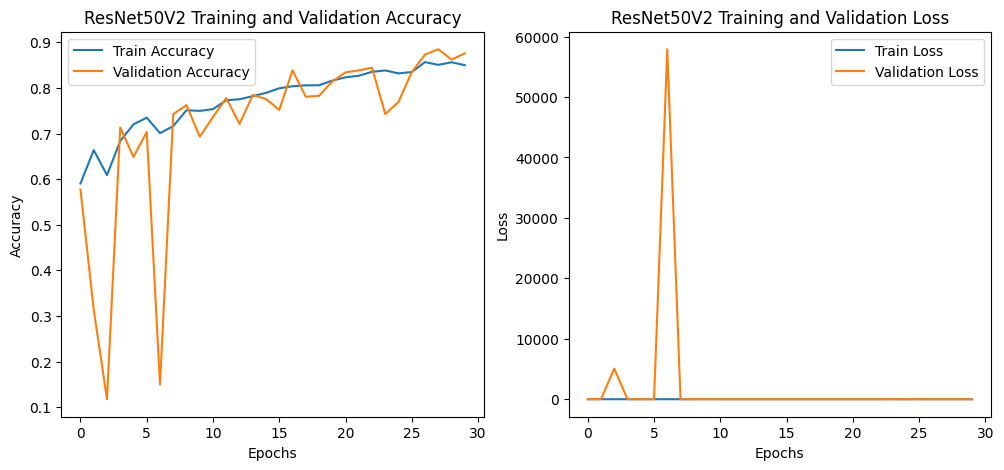

In [12]:
ResNet50V2_base_model = ResNet50V2(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
ResNet50V2_x = ResNet50V2_base_model.output
ResNet50V2_x = GlobalAveragePooling2D()(ResNet50V2_x)
ResNet50V2_x = Dense(1024, activation="relu")(ResNet50V2_x)
ResNet50V2_x = BatchNormalization()(ResNet50V2_x)
ResNet50V2_predictions = Dense(num_classes, activation="softmax")(ResNet50V2_x)
ResNet50V2_model = Model(
    inputs=ResNet50V2_base_model.input, outputs=ResNet50V2_predictions
)

ResNet50V2_model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        F1Score(name="f1_score"),
    ],
)

# Data Augmentation
ResNet50V2_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Calculate class weights
ResNet50V2_train_labels_int = np.argmax(train_labels, axis=1)
ResNet50V2_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(ResNet50V2_train_labels_int),
    y=ResNet50V2_train_labels_int,
)
ResNet50V2_class_weights_dict = dict(enumerate(ResNet50V2_class_weights))

# %% Train the Model
print("Training model...")
ResNet50V2_history = ResNet50V2_model.fit(
    ResNet50V2_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    class_weight=ResNet50V2_class_weights_dict,
)

ResNet50V2_model.save("ResNet50V2_model.h5")

# Accuracy
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(ResNet50V2_history.history["accuracy"], label="Train Accuracy")
plt.plot(ResNet50V2_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("ResNet50V2 Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(ResNet50V2_history.history["loss"], label="Train Loss")
plt.plot(ResNet50V2_history.history["val_loss"], label="Validation Loss")
plt.title("ResNet50V2 Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### Confusion Matrix

Validation accuracy: 0.8751
Validation loss: 0.3183
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 313ms/step


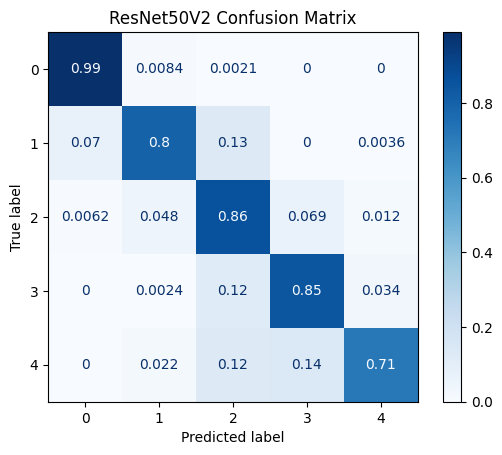

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

model = load_model("ResNet50V2_model.h5")

test = ResNet50V2_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test[1]:.4f}")
print(f"Validation loss: {test[0]:.4f}")

# Predict and compute confusion matrix
ResNet50V2_y_val_pred = ResNet50V2_model.predict(X_val)
ResNet50V2_y_val_pred_classes = np.argmax(ResNet50V2_y_val_pred, axis=1)
ResNet50V2_y_val_true = np.argmax(y_val, axis=1)
ResNet50V2_conf_matrix = confusion_matrix(
    ResNet50V2_y_val_true, ResNet50V2_y_val_pred_classes
)
ResNet50V2_normalized_conf_matrix = (
    ResNet50V2_conf_matrix.astype("float")
    / ResNet50V2_conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=ResNet50V2_normalized_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("ResNet50V2 Confusion Matrix")
plt.show()

### DenseNet201 Model

Training model...
Epoch 1/30


c:\Users\User\Desktop\from pendrive\Thesis\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 255s 6s/step - accuracy: 0.4907 - f1_score: 0.4154 - loss: 2.0160 - precision: 0.5595 - recall: 0.4444 - val_accuracy: 0.2277 - val_f1_score: 0.1029 - val_loss: 157.3517 - val_precision: 0.2277 - val_recall: 0.2277 - learning_rate: 0.0010
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 185s 6s/step - accuracy: 0.6315 - f1_score: 0.5680 - loss: 1.0319 - precision: 0.7933 - recall: 0.4670 - val_accuracy: 0.1041 - val_f1_score: 0.0377 - val_loss: 1127.3787 - val_precision: 0.1041 - val_recall: 0.1041 - learning_rate: 0.0010
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 184s 6s/step - accuracy: 0.6449 - f1_score: 0.5649 - loss: 0.9420 - precision: 0.8246 - recall: 0.4913 - val_accuracy: 0.2342 - val_f1_score: 0.1977 - val_loss: 9.3375 - val_precision: 0.2313 - val_recall: 0.2182 - learning_rate: 0.0010
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 189s 6s/step - accuracy: 0.6773 - f1_score: 0.6272 - loss: 0.9150 - precision: 0.8319 - recall: 0.5623 - val_accuracy: 0.6670 - val_f1_score: 0

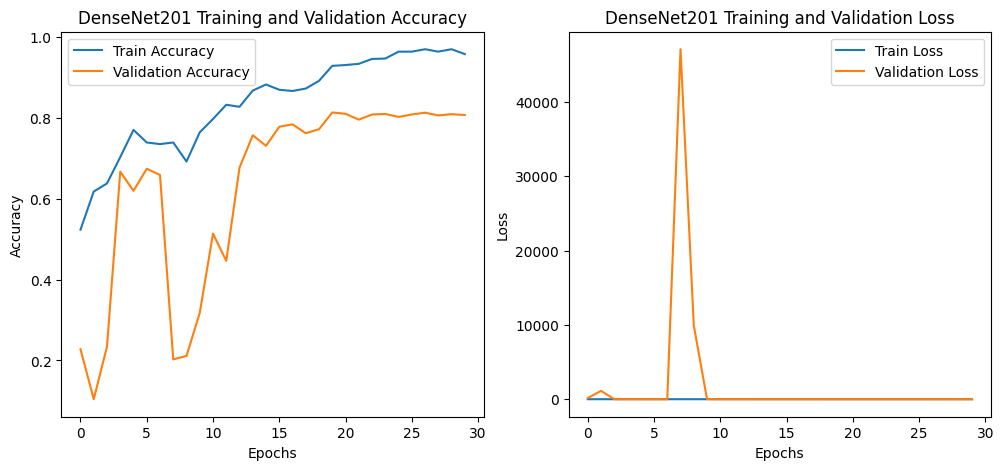

In [23]:
DenseNet201_base_model = DenseNet201(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
DenseNet201_x = DenseNet201_base_model.output
DenseNet201_x = GlobalAveragePooling2D()(DenseNet201_x)
DenseNet201_x = Dense(1024, activation="relu")(DenseNet201_x)
DenseNet201_x = BatchNormalization()(DenseNet201_x)
DenseNet201_predictions = Dense(num_classes, activation="softmax")(DenseNet201_x)
DenseNet201_model = Model(
    inputs=DenseNet201_base_model.input, outputs=DenseNet201_predictions
)

DenseNet201_model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        F1Score(name="f1_score"),
    ],
)

# Data Augmentation
DenseNet201_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Calculate class weights
DenseNet201_train_labels_int = np.argmax(train_labels, axis=1)
DenseNet201_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(DenseNet201_train_labels_int),
    y=DenseNet201_train_labels_int,
)
DenseNet201_class_weights_dict = dict(enumerate(DenseNet201_class_weights))

# %% Train the Model
print("Training model...")
DenseNet201_history = DenseNet201_model.fit(
    DenseNet201_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    class_weight=DenseNet201_class_weights_dict,
)

DenseNet201_model.save("DenseNet201_model.h5")

# Accuracy
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(DenseNet201_history.history["accuracy"], label="Train Accuracy")
plt.plot(DenseNet201_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("DenseNet201 Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(DenseNet201_history.history["loss"], label="Train Loss")
plt.plot(DenseNet201_history.history["val_loss"], label="Validation Loss")
plt.title("DenseNet201 Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### Confusion Matrix

Validation accuracy: 0.8696
Validation loss: 0.4860
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 712ms/step


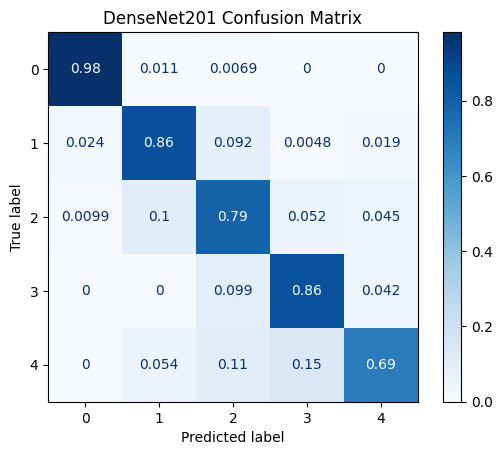

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

model = load_model("DenseNet201_model.h5")

test = DenseNet201_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test[1]:.4f}")
print(f"Validation loss: {test[0]:.4f}")

# Predict and compute confusion matrix
DenseNet201_y_val_pred = DenseNet201_model.predict(X_val)
DenseNet201_y_val_pred_classes = np.argmax(DenseNet201_y_val_pred, axis=1)
DenseNet201_y_val_true = np.argmax(y_val, axis=1)
DenseNet201_conf_matrix = confusion_matrix(
    DenseNet201_y_val_true, DenseNet201_y_val_pred_classes
)
DenseNet201_normalized_conf_matrix = (
    DenseNet201_conf_matrix.astype("float")
    / DenseNet201_conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=DenseNet201_normalized_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("DenseNet201 Confusion Matrix")
plt.show()

### DenseNet169 Model

Training model...
Epoch 1/30


c:\Users\User\Desktop\from pendrive\Thesis\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.5651 - f1_score: 0.5012 - loss: 1.5255 - precision: 0.6488 - recall: 0.4718 - val_accuracy: 0.5687 - val_f1_score: 0.4565 - val_loss: 2.0654 - val_precision: 0.5704 - val_recall: 0.5647 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.7023 - f1_score: 0.6373 - loss: 0.8608 - precision: 0.7937 - recall: 0.6119 - val_accuracy: 0.6038 - val_f1_score: 0.4928 - val_loss: 1.0560 - val_precision: 0.6335 - val_recall: 0.5817 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.7617 - f1_score: 0.7048 - loss: 0.7171 - precision: 0.8440 - recall: 0.6724 - val_accuracy: 0.6013 - val_f1_score: 0.5338 - val_loss: 0.9865 - val_precision: 0.6512 - val_recall: 0.5281 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.7823 - f1_score: 0.7219 - loss: 0.6376 - precision: 0.8407 - recall: 0.7228 - val_accuracy: 0.7307 - val_f1_score: 0.6317

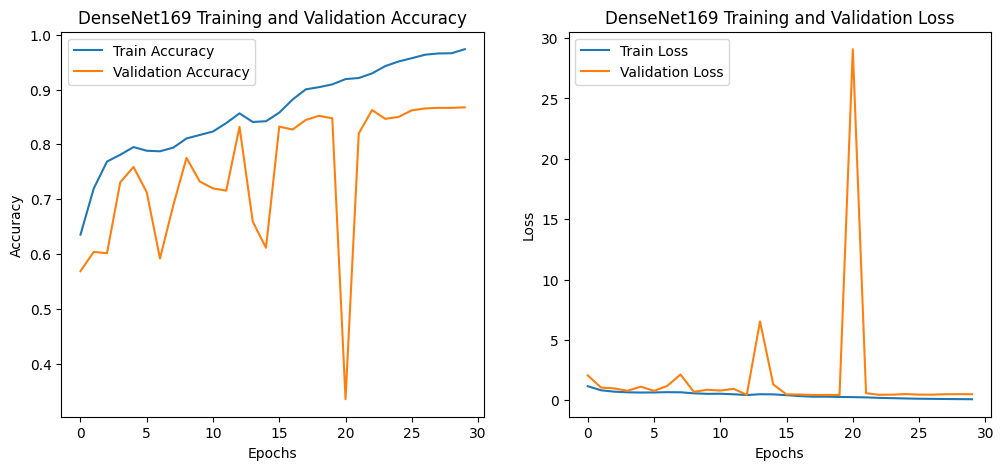

In [55]:
DenseNet169_base_model = DenseNet169(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
DenseNet169_x = DenseNet169_base_model.output
DenseNet169_x = GlobalAveragePooling2D()(DenseNet169_x)
DenseNet169_x = Dense(1024, activation="relu")(DenseNet169_x)
DenseNet169_x = BatchNormalization()(DenseNet169_x)
DenseNet169_predictions = Dense(num_classes, activation="softmax")(DenseNet169_x)
DenseNet169_model = Model(
    inputs=DenseNet169_base_model.input, outputs=DenseNet169_predictions
)

DenseNet169_model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        F1Score(name="f1_score"),
    ],
)

# Data Augmentation
DenseNet169_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Calculate class weights
DenseNet169_train_labels_int = np.argmax(train_labels, axis=1)
DenseNet169_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(DenseNet169_train_labels_int),
    y=DenseNet169_train_labels_int,
)
DenseNet169_class_weights_dict = dict(enumerate(DenseNet169_class_weights))

# Train the Model
print("Training model...")
DenseNet169_history = DenseNet169_model.fit(
    DenseNet169_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    class_weight=DenseNet169_class_weights_dict,
)

DenseNet169_model.save("DenseNet169_model.h5")

# Accuracy
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(DenseNet169_history.history["accuracy"], label="Train Accuracy")
plt.plot(DenseNet169_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("DenseNet169 Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(DenseNet169_history.history["loss"], label="Train Loss")
plt.plot(DenseNet169_history.history["val_loss"], label="Validation Loss")
plt.title("DenseNet169 Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### Confusion Matrix

Validation accuracy: 0.9414
Validation loss: 0.2240
156/156 ━━━━━━━━━━━━━━━━━━━━ 80s 499ms/step


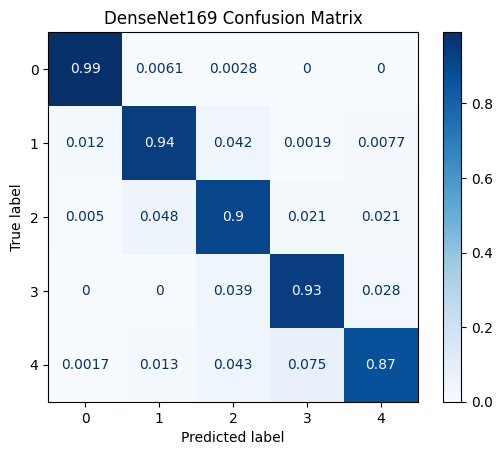

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

DenseNet169_model = load_model("DenseNet169_model.h5")

test = DenseNet169_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test[1]:.4f}")
print(f"Validation loss: {test[0]:.4f}")

# Predict and compute confusion matrix
DenseNet169_y_val_pred = DenseNet169_model.predict(X_val)
DenseNet169_y_val_pred_classes = np.argmax(DenseNet169_y_val_pred, axis=1)
DenseNet169_y_val_true = np.argmax(y_val, axis=1)
DenseNet169_conf_matrix = confusion_matrix(
    DenseNet169_y_val_true, DenseNet169_y_val_pred_classes
)
DenseNet169_normalized_conf_matrix = (
    DenseNet169_conf_matrix.astype("float")
    / DenseNet169_conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=DenseNet169_normalized_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("DenseNet169 Confusion Matrix")
plt.show()

### InceptionV3 Model

Training model...
Epoch 1/30


c:\Users\User\Desktop\from pendrive\Thesis\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.4859 - f1_score: 0.4315 - loss: 1.5706 - precision: 0.6404 - recall: 0.3279 - val_accuracy: 0.3977 - val_f1_score: 0.1969 - val_loss: 24.1436 - val_precision: 0.4091 - val_recall: 0.3701 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 92s 971ms/step - accuracy: 0.6912 - f1_score: 0.6117 - loss: 0.9017 - precision: 0.8301 - recall: 0.5487 - val_accuracy: 0.6665 - val_f1_score: 0.5446 - val_loss: 0.8083 - val_precision: 0.8094 - val_recall: 0.5431 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 92s 968ms/step - accuracy: 0.7339 - f1_score: 0.6808 - loss: 0.7814 - precision: 0.8332 - recall: 0.6365 - val_accuracy: 0.7447 - val_f1_score: 0.6844 - val_loss: 0.7589 - val_precision: 0.8558 - val_recall: 0.5687 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 91s 960ms/step - accuracy: 0.7718 - f1_score: 0.7134 - loss: 0.6892 - precision: 0.8382 - recall: 0.6979 - val_accuracy: 0.2247 - val_f1_score:

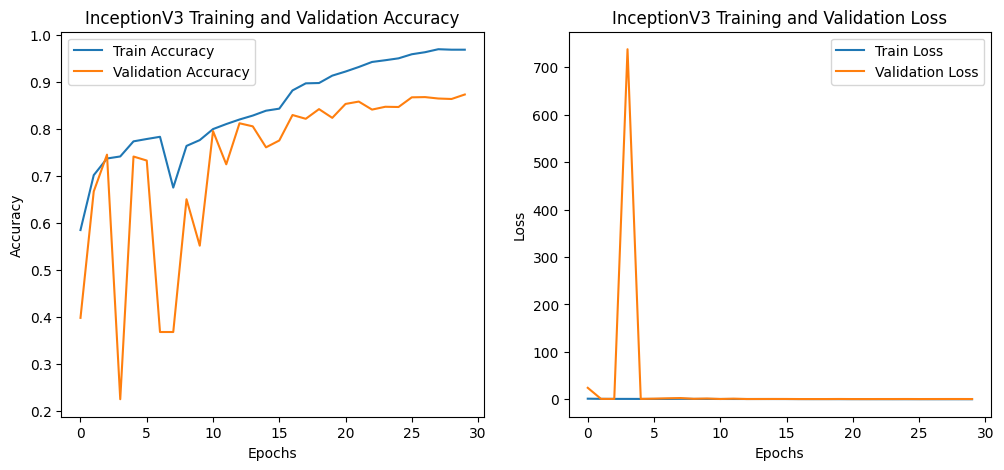

In [10]:
InceptionV3_base_model = InceptionV3(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
InceptionV3_x = InceptionV3_base_model.output
InceptionV3_x = GlobalAveragePooling2D()(InceptionV3_x)
InceptionV3_x = Dense(1024, activation="relu")(InceptionV3_x)
InceptionV3_x = BatchNormalization()(InceptionV3_x)
InceptionV3_predictions = Dense(num_classes, activation="softmax")(InceptionV3_x)
InceptionV3_model = Model(
    inputs=InceptionV3_base_model.input, outputs=InceptionV3_predictions
)

InceptionV3_model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        F1Score(name="f1_score"),
    ],
)

# Data Augmentation
InceptionV3_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Calculate class weights
InceptionV3_train_labels_int = np.argmax(train_labels, axis=1)
InceptionV3_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(InceptionV3_train_labels_int),
    y=InceptionV3_train_labels_int,
)
InceptionV3_class_weights_dict = dict(enumerate(InceptionV3_class_weights))

# Train the Model
print("Training model...")
InceptionV3_history = InceptionV3_model.fit(
    InceptionV3_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    class_weight=InceptionV3_class_weights_dict,
)

InceptionV3_model.save("InceptionV3_model.h5")

# Accuracy
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(InceptionV3_history.history["accuracy"], label="Train Accuracy")
plt.plot(InceptionV3_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("InceptionV3 Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(InceptionV3_history.history["loss"], label="Train Loss")
plt.plot(InceptionV3_history.history["val_loss"], label="Validation Loss")
plt.title("InceptionV3 Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### Confusion Matrix

Validation accuracy: 0.8726
Validation loss: 0.5104
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step


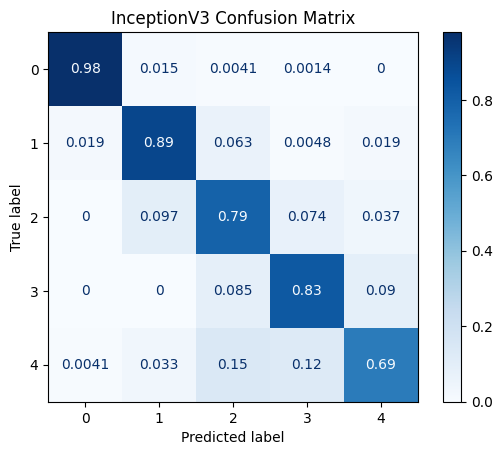

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

model = load_model("InceptionV3_model.h5")

test = InceptionV3_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test[1]:.4f}")
print(f"Validation loss: {test[0]:.4f}")

# Predict and compute confusion matrix
InceptionV3_y_val_pred = InceptionV3_model.predict(X_val)
InceptionV3_y_val_pred_classes = np.argmax(InceptionV3_y_val_pred, axis=1)
InceptionV3_y_val_true = np.argmax(y_val, axis=1)
InceptionV3_conf_matrix = confusion_matrix(
    InceptionV3_y_val_true, InceptionV3_y_val_pred_classes
)
InceptionV3_normalized_conf_matrix = (
    InceptionV3_conf_matrix.astype("float")
    / InceptionV3_conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=InceptionV3_normalized_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("InceptionV3 Confusion Matrix")
plt.show()

### InceptionResNetV2 Model

Training model...
Epoch 1/30


c:\Users\User\Desktop\from pendrive\Thesis\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.5512 - f1_score: 0.4876 - loss: 1.4874 - precision: 0.6680 - recall: 0.4155 - val_accuracy: 0.2894 - val_f1_score: 0.1131 - val_loss: 2713.4175 - val_precision: 0.2922 - val_recall: 0.2894 - learning_rate: 0.0010
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.7385 - f1_score: 0.6803 - loss: 0.8161 - precision: 0.8106 - recall: 0.6463 - val_accuracy: 0.5747 - val_f1_score: 0.3975 - val_loss: 283.3417 - val_precision: 0.6865 - val_recall: 0.4865 - learning_rate: 0.0010
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7615 - f1_score: 0.7025 - loss: 0.6914 - precision: 0.8205 - recall: 0.6975 - val_accuracy: 0.7618 - val_f1_score: 0.7091 - val_loss: 0.6750 - val_precision: 0.8307 - val_recall: 0.6570 - learning_rate: 0.0010
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.7795 - f1_score: 0.7321 - loss: 0.6876 - precision: 0.8360 - recall: 0.7133 - val_accuracy: 0.3701 - val_f1_score: 0

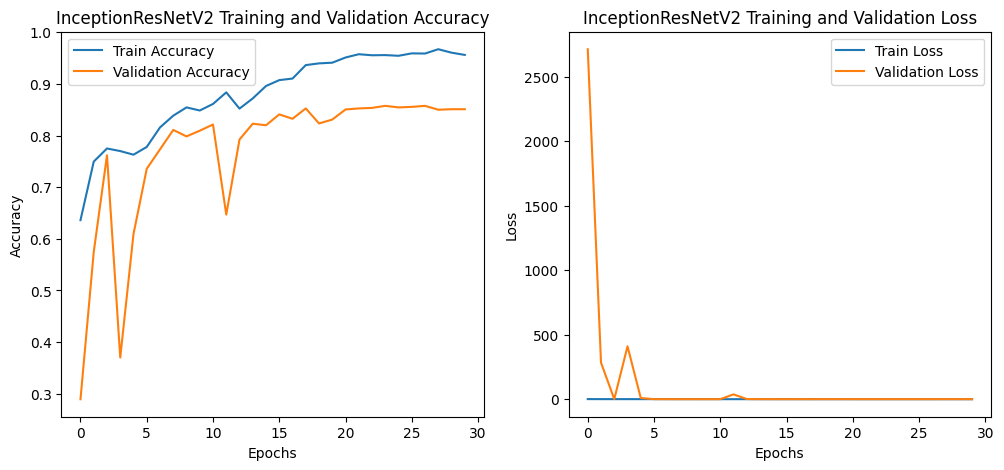

In [11]:
InceptionResNetV2_base_model = InceptionResNetV2(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
InceptionResNetV2_x = InceptionResNetV2_base_model.output
InceptionResNetV2_x = GlobalAveragePooling2D()(InceptionResNetV2_x)
InceptionResNetV2_x = Dense(1024, activation="relu")(InceptionResNetV2_x)
InceptionResNetV2_x = BatchNormalization()(InceptionResNetV2_x)
InceptionResNetV2_predictions = Dense(num_classes, activation="softmax")(InceptionResNetV2_x)
InceptionResNetV2_model = Model(
    inputs=InceptionResNetV2_base_model.input, outputs=InceptionResNetV2_predictions
)

InceptionResNetV2_model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        F1Score(name="f1_score"),
    ],
)

# Data Augmentation
InceptionResNetV2_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

# Calculate class weights
InceptionResNetV2_train_labels_int = np.argmax(train_labels, axis=1)
InceptionResNetV2_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(InceptionResNetV2_train_labels_int),
    y=InceptionResNetV2_train_labels_int,
)
InceptionResNetV2_class_weights_dict = dict(enumerate(InceptionResNetV2_class_weights))

# %% Train the Model
print("Training model...")
InceptionResNetV2_history = InceptionResNetV2_model.fit(
    InceptionResNetV2_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    class_weight=InceptionResNetV2_class_weights_dict,
)

InceptionResNetV2_model.save("InceptionResNetV2_model.h5")

# Accuracy
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(InceptionResNetV2_history.history["accuracy"], label="Train Accuracy")
plt.plot(InceptionResNetV2_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("InceptionResNetV2 Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(InceptionResNetV2_history.history["loss"], label="Train Loss")
plt.plot(InceptionResNetV2_history.history["val_loss"], label="Validation Loss")
plt.title("InceptionResNetV2 Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### Confusion Matrix model

Validation accuracy: 0.9418
Validation loss: 0.2261
156/156 ━━━━━━━━━━━━━━━━━━━━ 28s 176ms/step


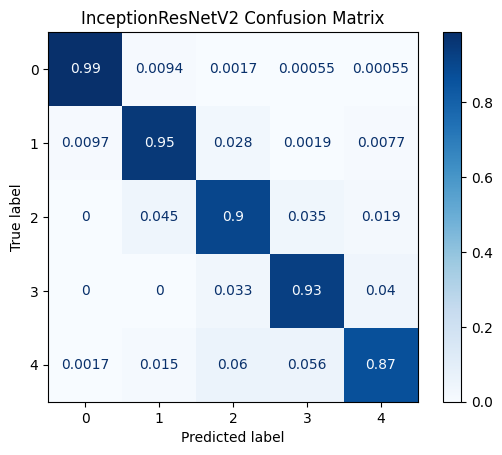

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

InceptionV3_model = load_model("InceptionV3_model.h5")

test = InceptionV3_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test[1]:.4f}")
print(f"Validation loss: {test[0]:.4f}")

# Predict and compute confusion matrix
InceptionV3_y_val_pred = InceptionV3_model.predict(X_val)
InceptionV3_y_val_pred_classes = np.argmax(InceptionV3_y_val_pred, axis=1)
InceptionV3_y_val_true = np.argmax(y_val, axis=1)
InceptionV3_conf_matrix = confusion_matrix(
    InceptionV3_y_val_true, InceptionV3_y_val_pred_classes
)
InceptionV3_normalized_conf_matrix = (
    InceptionV3_conf_matrix.astype("float")
    / InceptionV3_conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=InceptionV3_normalized_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("InceptionResNetV2 Confusion Matrix")
plt.show()

### AR_Model Model

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.4771 - f1_score: 0.3824 - loss: 1.3881 - precision: 0.6078 - recall: 0.3473 - val_accuracy: 0.2072 - val_f1_score: 0.0687 - val_loss: 1.7007 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.6245 - f1_score: 0.5200 - loss: 0.9655 - precision: 0.7753 - recall: 0.5045 - val_accuracy: 0.2072 - val_f1_score: 0.0687 - val_loss: 1.7294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.6557 - f1_score: 0.5536 - loss: 0.8733 - precision: 0.8025 - recall: 0.5225 - val_accuracy: 0.2072 - val_f1_score: 0.0687 - val_loss: 1.7253 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.6793 - f1_score: 0.5906 - loss: 0.8311 - precision: 0.8100 - recall: 0.5530 - val_accuracy: 0.2072 - val_f1_score: 0.0687 - val_loss: 1.7110 - val_precision: 

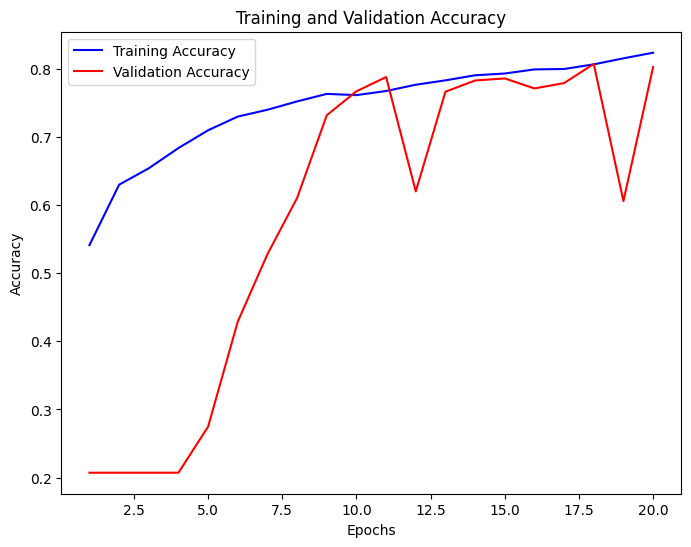

In [140]:
from tensorflow.keras import layers, models, regularizers


def create_ar_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # First block: Depthwise separable conv
    x = layers.Conv2D(32, (3, 3), padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Depthwise separable convolution block 1
    x = layers.SeparableConv2D(64, (3, 3), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Depthwise separable convolution block 2 with residual connection
    residual = layers.Conv2D(
        128, (1, 1), strides=(2, 2), padding="same", use_bias=False
    )(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.SeparableConv2D(
        128, (3, 3), padding="same", strides=(2, 2), use_bias=False
    )(
        x
    )  # Downsample main path
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.SeparableConv2D(128, (3, 3), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])  # Residual connection
    x = layers.ReLU()(x)

    # Depthwise separable convolution block 3
    residual = layers.Conv2D(
        256, (1, 1), strides=(2, 2), padding="same", use_bias=False
    )(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.SeparableConv2D(
        256, (3, 3), padding="same", strides=(2, 2), use_bias=False
    )(
        x
    )  # Downsample main path
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.SeparableConv2D(256, (3, 3), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])  # Residual connection
    x = layers.ReLU()(x)

    # Global Average Pooling and Dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Regularization

    # Output Layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Model definition
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            Precision(name="precision"),
            Recall(name="recall"),
            F1Score(name="f1_score")
        ],
    )

    return model


input_shape = (224, 224, 3)
num_classes = 5

ar_model = create_ar_model(input_shape, num_classes)

# Train the model
ar_model_history = ar_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
)


acc = ar_model_history.history["accuracy"]
val_acc = ar_model_history.history["val_accuracy"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, "b", label="Training Accuracy")
plt.plot(epochs, val_acc, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


ar_model.save("AR_Model.h5")

#### Confusion Matrix

Validation accuracy: 0.8022
Validation loss: 0.5461
156/156 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step


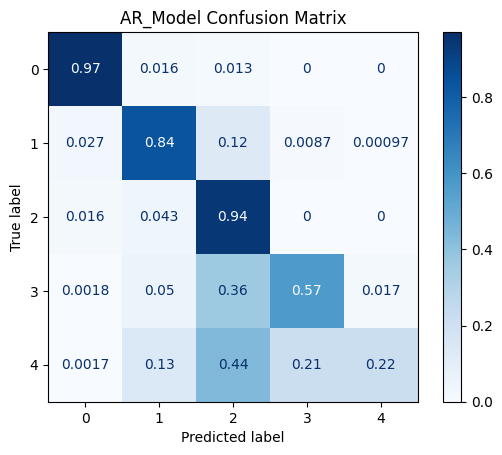

In [141]:
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

AR_Model = load_model("AR_Model.h5")

test = AR_Model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test[1]:.4f}")
print(f"Validation loss: {test[0]:.4f}")

# Predict and compute confusion matrix
AR_Model_y_val_pred = AR_Model.predict(X_val)
AR_Model_y_val_pred_classes = np.argmax(AR_Model_y_val_pred, axis=1)
AR_Model_y_val_true = np.argmax(y_val, axis=1)
AR_Model_conf_matrix = confusion_matrix(
    AR_Model_y_val_true, AR_Model_y_val_pred_classes
)
AR_Model_normalized_conf_matrix = (
    AR_Model_conf_matrix.astype("float")
    / AR_Model_conf_matrix.sum(axis=1)[:, np.newaxis]
)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=AR_Model_normalized_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("AR_Model Confusion Matrix")
plt.show()

### Ensemble Model

156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 63s 401ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 49s 311ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 102s 635ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 81s 502ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 29s 179ms/step
Ensemble Model Performance:
Accuracy: 0.9819458375125376
Precision: 0.9820159592018635
Recall: 0.9819458375125376
F1 Score: 0.9819538770565042
Loss: 0.2065446935594082


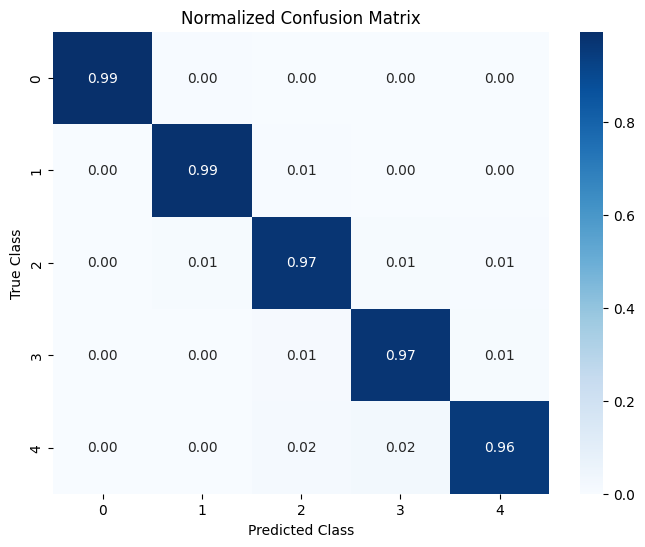

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the trained models
mobilenet = load_model("MobileNet_model.h5")
mobilenetv2 = load_model("MobileNetV2_model.h5")
xception = load_model("Xception_model.h5")
resnet50v2 = load_model("ResNet50V2_model.h5")
densenet201 = load_model("DenseNet201_model.h5")
densenet169 = load_model("DenseNet169_model.h5")
inceptionv3 = load_model("InceptionV3_model.h5")

# List of models to be used in the ensemble
models = [mobilenet, mobilenetv2, xception, resnet50v2, densenet201, densenet169, inceptionv3]

# Function to predict using an ensemble of models on validation data
def ensemble_predict(models, X_val):
    # Get predictions from each model
    preds = [model.predict(X_val, verbose=1) for model in models]
    
    # Average the predictions (soft voting)
    avg_preds = np.mean(preds, axis=0)
    
    # Convert averaged predictions to class labels
    final_pred_classes = np.argmax(avg_preds, axis=1)
    
    return final_pred_classes

# Predict on the validation data using the ensemble
val_pred_classes = ensemble_predict(models, X_val)

# Get the true class labels
val_true_classes = np.argmax(y_val, axis=1)

# Evaluate the ensemble model
accuracy = accuracy_score(val_true_classes, val_pred_classes)
precision = precision_score(val_true_classes, val_pred_classes, average="weighted")
recall = recall_score(val_true_classes, val_pred_classes, average="weighted")
f1 = f1_score(val_true_classes, val_pred_classes, average="weighted")

val_losses = [model.evaluate(X_val, y_val, verbose=0)[0] for model in models]
ensemble_loss = np.mean(val_losses)

print("Ensemble Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Loss: {ensemble_loss}")

# Confusion Matrix (Normalized)
conf_matrix = confusion_matrix(val_true_classes, val_pred_classes, normalize='true')

# Plot Normalized Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.unique(val_true_classes), yticklabels=np.unique(val_true_classes))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

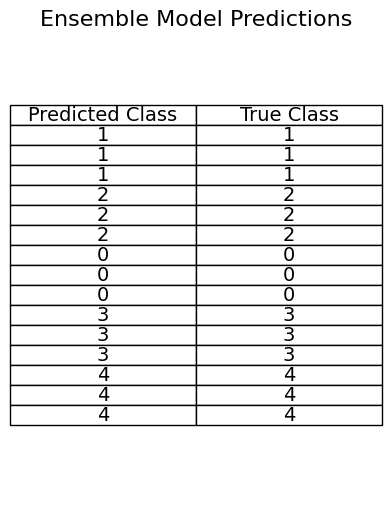

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model

# Load the trained models
mobilenet = load_model("MobileNet_model.h5")
mobilenetv2 = load_model("MobileNetV2_model.h5")
xception = load_model("Xception_model.h5")
resnet50v2 = load_model("ResNet50V2_model.h5")
densenet201 = load_model("DenseNet201_model.h5")
densenet169 = load_model("DenseNet169_model.h5")
inceptionv3 = load_model("InceptionV3_model.h5")

# List of models to be used in the ensemble
models = [
    mobilenet,
    mobilenetv2,
    xception,
    resnet50v2,
    densenet201,
    densenet169,
    inceptionv3,
]


# Function to preprocess a single image (resize and normalize)
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


# Function to preprocess multiple images
def preprocess_multiple_images(image_paths, target_size=(224, 224)):
    img_arrays = [preprocess_image(img_path, target_size) for img_path in image_paths]
    return np.vstack(img_arrays)


# Function to get ensemble predictions from multiple models
def ensemble_predict(models, img_array):
    # Get predictions from each model
    preds = [model.predict(img_array, verbose=0) for model in models]

    # Average the predictions (soft voting)
    avg_preds = np.mean(preds, axis=0)

    # Convert the averaged predictions to class labels
    final_pred_classes = np.argmax(avg_preds, axis=1)

    return final_pred_classes


# Input paths for 12 images
image_paths = [
    "./colored_images/Mild/0024cdab0c1e.png",
    "./colored_images/Mild/00cb6555d108.png",
    "./colored_images/Mild/0124dffecf29.png",
    "./colored_images/Moderate/000c1434d8d7.png",
    "./colored_images/Moderate/00a8624548a9.png",
    "./colored_images/Moderate/00b74780d31d.png",
    "./colored_images/No_DR/002c21358ce6.png",
    "./colored_images/No_DR/005b95c28852.png",
    "./colored_images/No_DR/0097f532ac9f.png",
    "./aptos2019-blindness-detection/train_images/0f96c358a250.png",
    "./aptos2019-blindness-detection/train_images/0c917c372572.png",
    "./aptos2019-blindness-detection/train_images/4f0866b90c27.png",
    "./aptos2019-blindness-detection/train_images/19244004583f.png",
    "./aptos2019-blindness-detection/train_images/3b232b394e4f.png",
    "./aptos2019-blindness-detection/train_images/46d3316c4857.png",
]

# Preprocess the 12 images
img_array = preprocess_multiple_images(image_paths)

predicted_classes = ensemble_predict(models, img_array)

true_labels = [1, 1, 1, 2, 2, 2, 0, 0, 0, 3, 3, 3, 4, 4, 4]

# Prepare data for DataFrame
data = {
    "Predicted Class": predicted_classes,
    "True Class": true_labels,
}

# Create a DataFrame
df = pd.DataFrame(data)

# Visualize the DataFrame as a table using matplotlib
fig, ax = plt.subplots(figsize=(4, 6))
ax.axis("tight")
ax.axis("off")
table_data = df.values
table = ax.table(
    cellText=table_data,
    colLabels=df.columns,
    cellLoc="center",
    loc="center",
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.2)

plt.title("Ensemble Model Predictions", fontsize=16)
plt.show()